In [15]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [16]:
BATCH_SIZE = 16
IMAGE_SIZE = 150

In [18]:
#Retrieve images and divide into three classes
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "./dataset_2",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,   
    shuffle=True
)

Found 4175 files belonging to 25 classes.


In [20]:
class_names = dataset.class_names
class_names

['Air Terjun Oenesu',
 'Air Terjun Tanggedu',
 'Air Terjun Tesbatan',
 'Bukit Wairinding',
 'Danau Kelimut',
 'Gua Rangko',
 'Lawa Darat Gili',
 'Lingko Spider Web Rice Field',
 'Pandar Island',
 'Pantai Koka',
 'Pantai Kolbano',
 'Pantai Mandorak',
 'Pantai Oetune',
 'Pantai Waecicu',
 'Pantai Walakiri',
 'Pantai Watu Parunu',
 'Pink Beach',
 'Pulau Kalong',
 'Pulau Kanawa',
 'Rumah Budaya Sumba',
 'Savana Puru Kambera',
 'Taman Nostalgia Kupang',
 'Wae Rebo Village',
 'Waikuri Lagoon',
 'Wisata Adat Kampung Todo']

(16, 150, 150, 3)
[20 21 18 21  1 13 19  8 13  4 13  3 21 15  8  4]


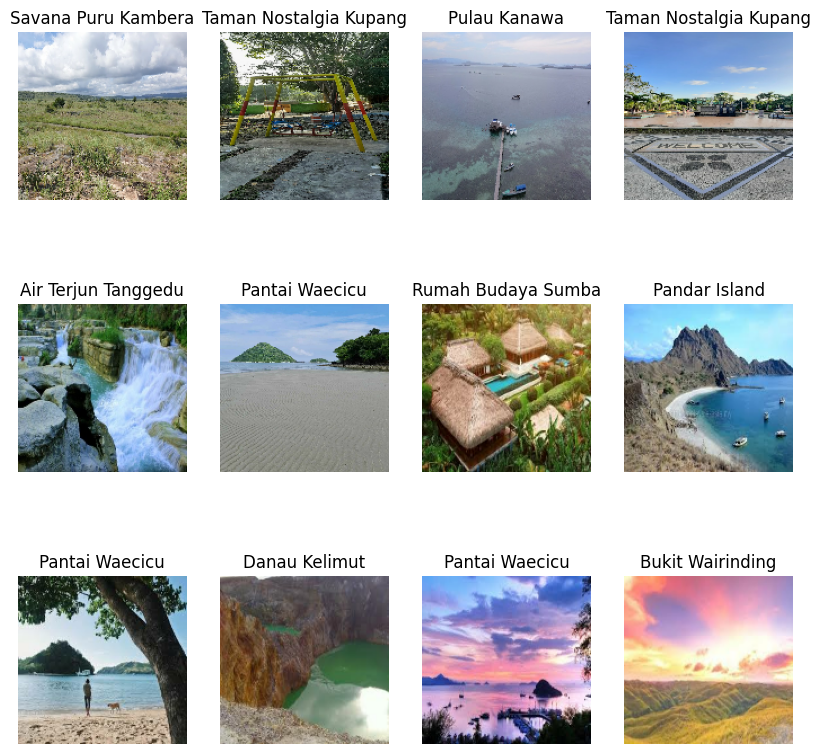

In [21]:
#Data Visualization
plt.figure(figsize=(10,10))
for image_batch , labels_batch in dataset.take(1):
    print(image_batch.numpy().shape)
    print(labels_batch.numpy())
    #num_images = image_batch.shape[0]
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [22]:
data = dataset.map(lambda x,y: (x/225.0, y))


In [23]:
data.as_numpy_iterator().next()[0].min()

0.0

In [24]:
data.as_numpy_iterator().next()[0].max()

1.1333333

In [25]:
dataset_size = len(data)
train_size = int(dataset_size * 0.8)
val_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - val_size

In [26]:
train_dataset = data.take(train_size)
val_dataset = data.skip(train_size).take(val_size)
test_dataset = data.skip(train_size+val_size)

In [29]:
len(train_dataset)
len(test_dataset)
len(val_dataset)

26

In [30]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [31]:
pre_trained_model = MobileNetV2(weights="imagenet",
                                include_top=False,
                                input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output

In [32]:
from tensorflow.keras.regularizers import l2
x = tf.keras.layers.Flatten(name="flatten")(last_output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(25, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']        

In [33]:
int_lr = 1e-4
num_epochs = 10

#optimizer = tf.optimizers.SGD(learning_rate=int_lr, momentum=0.9)
#optimizer = tf.optimizers.RMSprop()
optimizer = tf.optimizers.Adam(learning_rate = int_lr)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [34]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.85):
      print('val_accuracy > 0.82')
      self.model.stop_training = True


mycallback = myCallback()

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', min_delta=0.1)

H = model.fit(train_dataset,
              epochs=num_epochs,
              validation_data=val_dataset,
              callbacks=[early_stopping],
              #callbacks = mycallback
              )


Epoch 1/10


208/208 [==============================] - 69s 240ms/step - loss: 2.4754 - accuracy: 0.4654 - val_loss: 1.0552 - val_accuracy: 0.7452
Epoch 2/10
208/208 [==============================] - 36s 174ms/step - loss: 0.8350 - accuracy: 0.7797 - val_loss: 0.8646 - val_accuracy: 0.8029
Epoch 3/10
208/208 [==============================] - 40s 190ms/step - loss: 0.4671 - accuracy: 0.8603 - val_loss: 0.9674 - val_accuracy: 0.7764
Epoch 4/10
208/208 [==============================] - 34s 165ms/step - loss: 0.2930 - accuracy: 0.9078 - val_loss: 0.9120 - val_accuracy: 0.8221
Epoch 5/10
208/208 [==============================] - 36s 172ms/step - loss: 0.2006 - accuracy: 0.9366 - val_loss: 0.8701 - val_accuracy: 0.8173
Epoch 6/10
208/208 [==============================] - 35s 171ms/step - loss: 0.1459 - accuracy: 0.9552 - val_loss: 0.8608 - val_accuracy: 0.8317


In [36]:
score = model.evaluate(test_dataset)

27/27 [==============================] - 13s 149ms/step - loss: 1.1398 - accuracy: 0.7842


In [37]:
score

[1.1397794485092163, 0.7842227220535278]

In [38]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss = H.history['loss']
val_loss = H.history['val_loss']

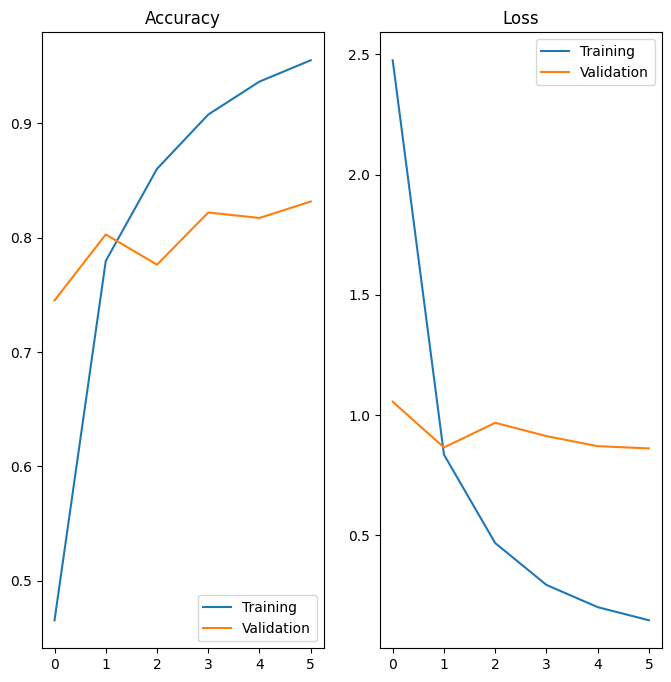

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(6), acc, label='Training')
plt.plot(range(6), val_acc, label='Validation')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(6), loss, label='Training')
plt.plot(range(6), val_loss, label='Validation')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

first image to predict
actual label: Air Terjun Oenesu
1/1 [==============================] - 3s 3s/step
predicted label: Air Terjun Tesbatan
first image to predict
actual label: Rumah Budaya Sumba
1/1 [==============================] - 0s 197ms/step
predicted label: Pulau Kalong
first image to predict
actual label: Pulau Kalong
1/1 [==============================] - 0s 206ms/step
predicted label: Pulau Kalong


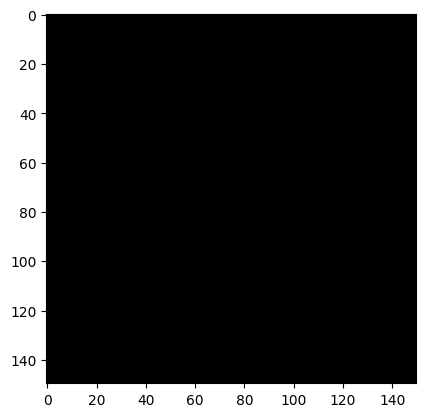

In [40]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(3):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 95ms/step


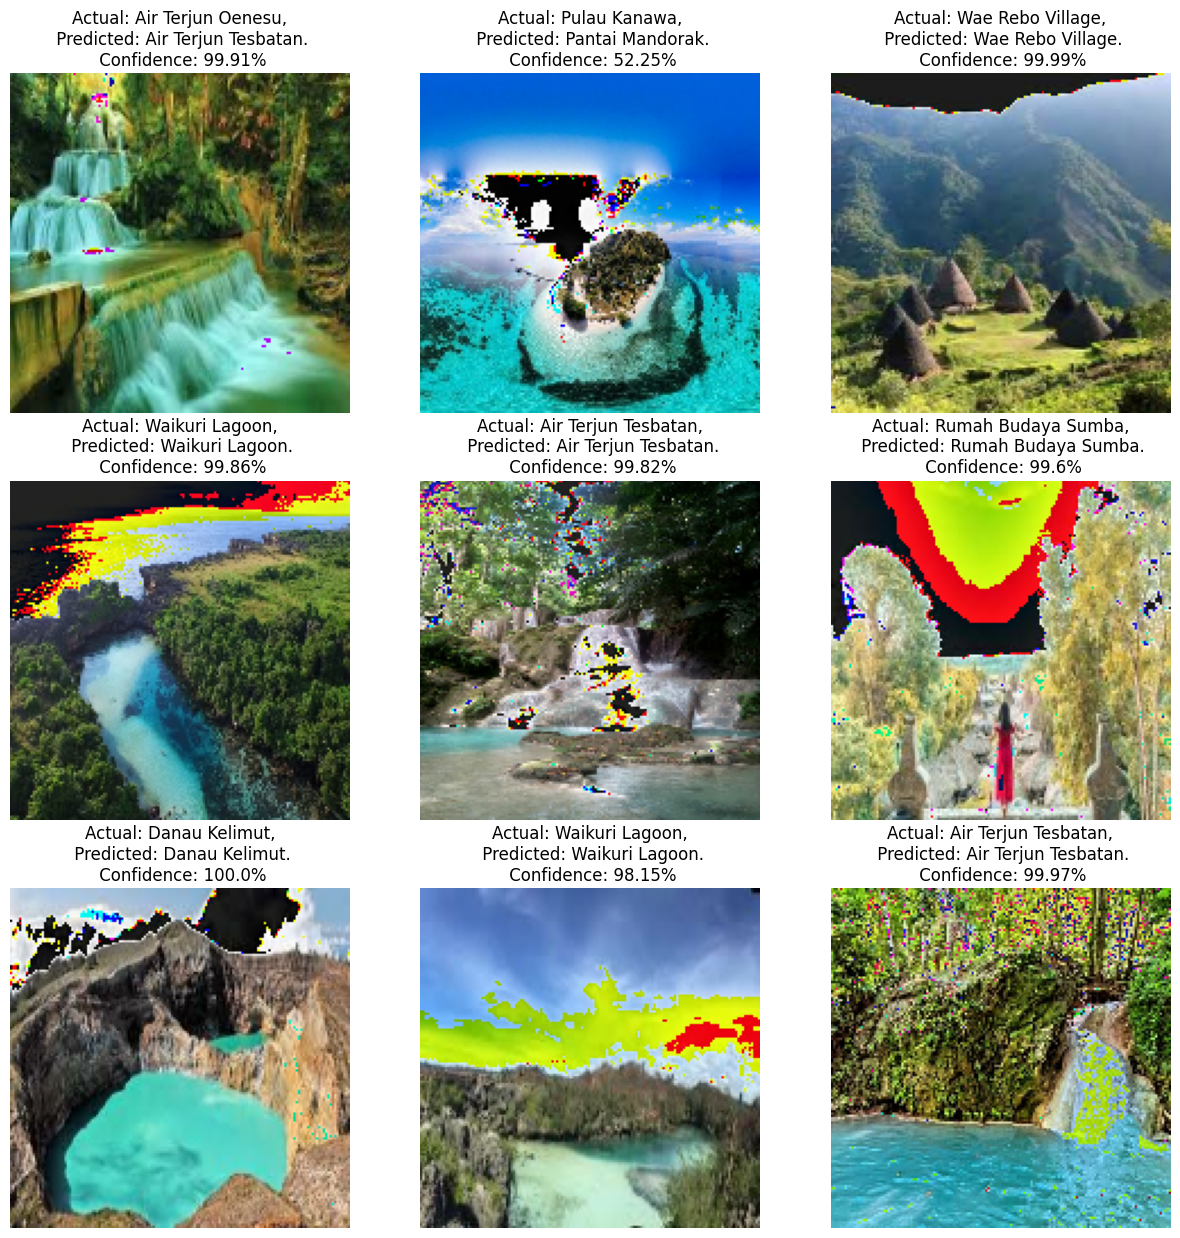

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = images*256.0
        plt.imshow(image[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
# import os
# model.save(os.path.join('models/h5', 'explorentt_mobilenet.h5'))

In [43]:
# !pip install tensorflowjs

In [ ]:
# !tensorflowjs_converter --input_format=keras ./models/h5/explorentt_mobilenet.h5 ./models/h5-tfjs